## Load the necessary libraries and files

In [20]:
import pandas as pd
import numpy as np

In [21]:
import os
import sys

# get source and data directories
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
data_dir = os.path.join(os.getcwd(), os.pardir, 'data/processed')

# set the source data directory as the current path
src_data_dir = os.path.join(src_dir, 'data')
sys.path.append(src_data_dir)

# load the paths to the csv data files
interest_file = os.path.join(data_dir, 'movie_interest.csv')
tmdb_file = os.path.join(data_dir, 'tmdb_data.csv')

# load the csv files into respective dataframes
interest_df = pd.read_csv(interest_file)
tmdb_df = pd.read_csv(tmdb_file)

In [22]:
# ignore scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Clean and transform the data

### Merge the data sets
Merge the datasets and do necessary cleaning

In [23]:
print(interest_df.shape)
print(tmdb_df.shape)

(5853, 5)
(3225, 10)


In [24]:
# title years are incompatible
print(interest_df['title_year'].dtype)
print(tmdb_df['title_year'].dtype)

object
int64


In [25]:
# identify and correct the row causing the type difference
interest_df[interest_df['title_year'] == 'TBA']
interest_df = interest_df.drop(2914)
interest_df['title_year'] = interest_df['title_year'].apply(int)

In [26]:
# merging the imdb data with the interest data on the movie title to create movie data frame (mdf)
mdf = pd.merge(tmdb_df, interest_df, how='inner', on=['movie_title', 'title_year'])
print(mdf.shape)

(1625, 13)


There are 5853 movies with wieghted interest scores and 3225 movies with data from tmdb. I'm only interested in the movies that have both imdb data (imdb_df) and interest score data (interest_df), so Inner Join the two dataframes to get the movies common in both. Go ahead and remove whatever duplicates there may be. Only 1625 common movie titles were remaining between the data sets.

### Remove duplicates
Take a look at the descriptive statistics to help identify what kind of data cleaning needs to be done:

In [27]:
# remove duplicates
#print(mdf.loc[mdf.duplicated()])
print(mdf.duplicated().sum())
mdf = mdf.drop_duplicates()

12


### Statistical summary

In [28]:
# look at shape and basic stats for variables
print(mdf.shape)
mdf.describe()

(1613, 13)


,revenue,popularity,budget,vote_count,vote_average,runtime,id,title_year,interest_score,rating,total_votes
count,1613.000,1613.000,1613.000,1613.000,1613.000,1613.000,1613.000,1613.000,1613.000,1613.000,1613.000
mean,151314794.578,36.069,51894443.779,1266.110,6.231,109.663,67075.626,2009.166,3.468,4.691,1469.752
std,207640006.842,45.119,50965054.163,1598.858,0.786,18.816,89410.549,4.037,2.298,6.432,3194.959
min,12.000,0.020,7000.000,3.000,3.000,63.000,13.000,1994.000,0.544,0.000,1.000
25%,29331068.000,14.819,17000000.000,298.000,5.700,97.000,9372.000,2006.000,2.902,1.000,7.000
50%,77208711.000,26.589,35000000.000,685.000,6.200,107.000,22821.000,2009.000,3.020,2.810,121.000
75%,173930596.000,44.108,70000000.000,1567.000,6.800,120.000,81188.000,2013.000,3.465,6.000,1508.000
max,1519557910.000,875.581,380000000.000,13752.000,8.300,338.000,417859.000,2016.000,28.796,91.000,32150.000


In [29]:
# get a clear count for these missing variables
print(np.isnan(mdf['revenue']).sum())
print(np.isnan(mdf['budget']).sum())

0
0


Observations:
- only 1,613 movies from the 3000+ collected are in both datasets disregarding duplicates
- all figures appear to be accounted for
- must make a distinction between popular and 
- title_year is a float -- convert to string
- some movies have suspiciously small revenues and budgets
- some movies had same name but different years, I had to go back and clean the interest data and join on title and year

### Clean the data

Converting the year variable to a string allows us to use it as a categorical variable

In [30]:
# convert year to a string
mdf['title_year'] = mdf['title_year'].apply(int)
mdf['title_year'] = mdf['title_year'].apply(str)

Removing very small revenues as I think they may have been entered incorrectly 

In [31]:
small_rev_idx = mdf[mdf['revenue'] < 5000].index
mdf = mdf.drop(small_rev_idx)

Let's add a profit margin variable

In [32]:
# add profit margin variable
mdf['profit_margin'] = mdf['revenue']/mdf['budget']

Drop the id column

In [33]:
mdf = mdf.drop('id', 1)

## How do different variables correlate with the Interest Score?

 .00-.19 “very weak”

 .20-.39 “weak”

 .40-.59 “moderate”

 .60-.79 “strong”

 .80-1.0 “very strong”

//anaconda/envs/DAND/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


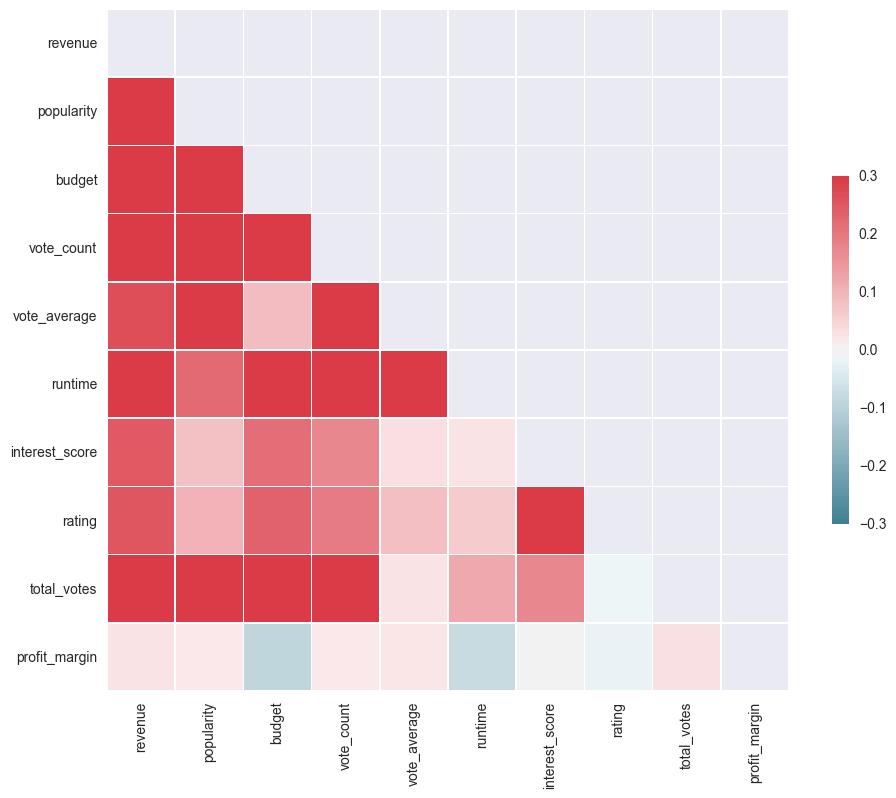

In [34]:
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import seaborn as sns

corr = mdf.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [35]:
# create sampling distribution for correlation
import random as rd

measure_corr_dict = {}

for measure in list(mdf.columns):
    corr_list = []
    if mdf[measure].dtype == object:
        print(measure)
        continue
    for set_iter in range(100):
        mdf_sample = mdf.sample(rd.randint(200,201))
        corr_list.append(mdf_sample['interest_score'].corr(mdf_sample[measure]))
    measure_corr_dict[measure] = np.array(corr_list).mean()

del measure_corr_dict['interest_score']
del measure_corr_dict['rating']
del measure_corr_dict['total_votes']
measure_corr_dict

genres
movie_title
title_year


{'budget': 0.22945632757927192,
 'popularity': 0.12105705439862849,
 'profit_margin': 0.0084737318269555752,
 'revenue': 0.27274321867598567,
 'runtime': 0.025844151419654057,
 'vote_average': 0.029933600084928912,
 'vote_count': 0.17476756602714449}

['revenue', 'popularity', 'budget', 'profit_margin', 'vote_count', 'vote_average', 'runtime']


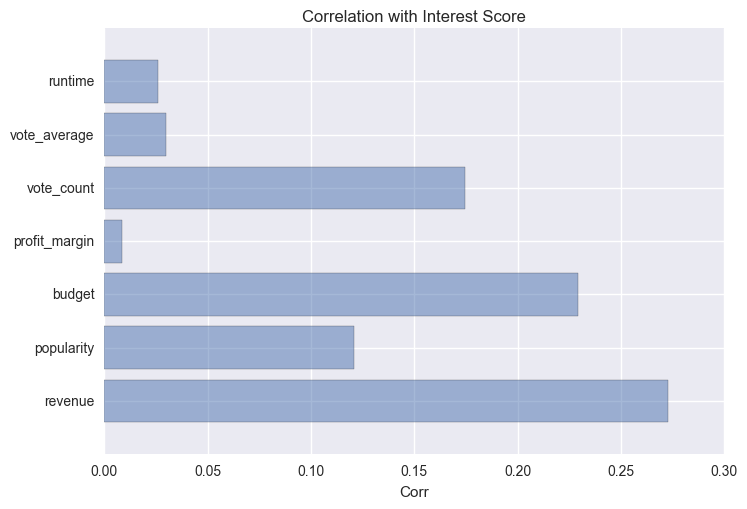

In [36]:
print(measure_corr_dict.keys())
y_pos = np.arange(len(measure_corr_dict.keys()))
vals = measure_corr_dict.values()
plt.barh(y_pos, vals, align = 'center', alpha = 0.5)
plt.yticks(y_pos, measure_corr_dict.keys())
plt.xlabel('Corr')
plt.title('Correlation with Interest Score')
plt.show()

In [37]:
mdf.describe()

,revenue,popularity,budget,vote_count,vote_average,runtime,interest_score,rating,total_votes,profit_margin
count,1609.000,1609.000,1609.000,1609.000,1609.000,1609.000,1609.000,1609.000,1609.000,1609.000
mean,151690965.544,36.137,51986163.962,1268.793,6.233,109.676,3.469,4.698,1473.398,4.651
std,207760739.577,45.153,50994461.816,1599.911,0.785,18.829,2.301,6.438,3198.092,19.899
min,17472.000,0.020,7000.000,3.000,3.000,63.000,0.544,0.000,1.000,0.001
25%,29657751.000,14.839,17000000.000,299.000,5.700,97.000,2.902,1.000,7.000,1.130
50%,77477008.000,26.620,35000000.000,688.000,6.200,107.000,3.020,2.810,122.000,2.301
75%,173965010.000,44.120,70000000.000,1570.000,6.800,120.000,3.465,6.000,1524.000,4.026
max,1519557910.000,875.581,380000000.000,13752.000,8.300,338.000,28.796,91.000,32150.000,439.617


### Overrated

Metrics
- **Popularity**: Based on a range of behaviors by users (mentions, likes, etc.) --Clarify later
- **Interest Score**: Based on the number of viewers who want to see the movies versus those who don't
- **Profit Margin**: Shows the discrepency between what was spent and what was earned
- **Vote Average**: Average vote the movie received in the TMDB data set

Some Issues: 
- Popularity metric is not well defined. Need more information on exactly what drives this metric and how to interpret it
- The sample of people who voted on movie insider (interest score) maybe different from the sample that voted on TMDB. Even if the interpretation of the variables are reasonable, such a difference would weaken 

In [25]:
mdf[mdf['popularity'] > 300].sort_values(by='profit_margin')

,genres,revenue,popularity,budget,vote_count,movie_title,vote_average,runtime,title_year,interest_score,rating,total_votes,profit_margin
111,Action|Adventure|Science Fiction|Thriller,378858340,434.279,150000000,9427,mad max fury road,7.200,120,2015,1.972,1.820,4344,2.526
82,Adventure|Drama|Science Fiction,675120017,724.248,165000000,10867,interstellar,8.100,169,2014,1.183,0.920,4398,4.092
81,Action|Science Fiction|Adventure,773328629,481.099,170000000,9742,guardians of the galaxy,7.900,121,2014,2.209,2.140,7386,4.549
23,Action|Adventure|Science Fiction|Thriller,1513528810,418.709,150000000,8662,jurassic world,6.500,124,2015,6.127,6.230,18923,10.090
503,Action|Adventure|Comedy,783112979,514.570,58000000,10995,deadpool,7.400,108,2016,13.265,13.640,17147,13.502
376,Family|Animation|Adventure|Comedy,1156730962,875.581,74000000,4571,minions,6.400,91,2015,3.792,3.830,12804,15.631


In [28]:
mdf[mdf['interest_score'] > 3.5].sort_values(by='profit_margin')

,genres,revenue,popularity,budget,vote_count,movie_title,vote_average,runtime,title_year,interest_score,rating,total_votes,profit_margin
1365,War|Drama,17479,5.728,20000000,62,5 days of war,5.800,113,2011,3.537,9.600,53,0.001
1487,Drama,399611,0.215,6000000,12,the 5th quarter,4.700,97,2011,3.591,5.340,203,0.067
927,Action|Thriller|Crime,2527904,13.269,30000000,286,machine gun preacher,6.400,129,2011,5.675,23.000,96,0.084
1311,Romance|Drama,1755212,24.211,14000000,418,flipped,7.400,89,2010,6.452,8.640,983,0.125
540,Action|Crime|Thriller,9489829,22.504,55000000,481,bullet to the head,5.200,92,2013,3.583,4.060,734,0.173
668,Comedy,7448385,9.420,41000000,248,the big year,5.600,100,2011,7.357,18.230,250,0.182
1255,Western|Drama,3442853,20.591,16000000,258,the homesman,6.400,122,2014,3.739,10.330,68,0.215
623,Action|Western|Drama|Fantasy|Thriller,10539000,22.581,47000000,420,jonah hex,4.400,80,2010,4.599,6.020,695,0.224
1176,Action|Comedy|Horror|Mystery|Science Fiction|T...,4634062,10.617,20000000,139,dylan dog dead of night,4.500,107,2011,3.966,7.230,181,0.232
665,Adventure|Fantasy|Action|Western|Thriller,11087569,7.349,42000000,136,the warriors way,6.300,100,2010,4.357,6.070,488,0.264


### Underrated

In [24]:
mdf[mdf['interest_score'] < 3].sort_values(by='profit_margin')

,genres,revenue,popularity,budget,vote_count,movie_title,vote_average,runtime,title_year,interest_score,rating,total_votes,profit_margin
1413,Drama|Thriller,17472,5.146,10000000,83,strangerland,5.100,111,2015,2.934,2.390,105,0.002
1490,Crime|Drama|Thriller,66351,10.190,12000000,224,deadfall,5.600,95,2012,1.950,0.710,544,0.006
1467,Crime|Thriller|Comedy,46488,8.207,7000000,73,cah,6.000,108,2010,2.939,1.530,38,0.007
1579,Drama,187674,5.160,13500000,32,stonewall,5.200,129,2015,2.873,2.050,116,0.014
1539,Drama,318982,18.790,16000000,291,adore,6.100,100,2013,2.981,2.670,88,0.020
1333,Drama|Romance|War,303877,4.267,10000000,45,in the land of blood and honey,5.800,127,2011,2.870,2.280,164,0.030
1558,Documentary,103735,1.781,3000000,36,freakonomics,6.600,93,2010,2.504,1.010,219,0.035
1087,Drama,970816,13.848,21000000,276,the beaver,6.300,91,2011,2.550,1.460,273,0.046
1529,Horror,187112,40.016,4000000,593,maggie,5.200,95,2015,1.715,0.890,997,0.047
1048,Action|Drama|Western,1397284,15.334,25000000,285,jane got a gun,5.400,98,2016,0.920,0.200,1834,0.056


In [40]:
mdf[mdf['budget'] > 51986163]

,genres,revenue,popularity,budget,vote_count,movie_title,vote_average,runtime,title_year,interest_score,rating,total_votes,profit_margin
0,Adventure|Fantasy|Action,961000000,139.083,300000000,4500,pirates of the caribbean at worlds end,6.900,169,2007,4.280,12.570,95,3.203
1,Action|Adventure|Crime,880674609,107.377,245000000,4466,spectre,6.300,148,2015,2.409,2.370,9903,3.595
2,Action|Crime|Drama|Thriller,1084939099,112.313,250000000,9106,the dark knight rises,7.600,165,2012,9.073,9.220,25809,4.340
3,Action|Adventure|Science Fiction,284139100,43.927,260000000,2124,john carter,6.100,132,2012,2.560,2.500,4894,1.093
4,Fantasy|Action|Adventure,890871626,115.700,258000000,3576,spiderman 3,5.900,139,2007,3.616,9.500,63,3.453
5,Animation|Family,591794936,48.682,260000000,3330,tangled,7.400,100,2010,5.876,8.150,787,2.276
6,Adventure|Fantasy|Family,933959197,98.886,250000000,5293,harry potter and the halfblood prince,7.400,153,2009,8.835,12.610,966,3.736
7,Action|Adventure|Fantasy,873260194,155.790,250000000,7004,batman v superman dawn of justice,5.700,151,2016,6.604,6.690,26064,3.493
8,Adventure|Fantasy|Action|Science Fiction,391081192,57.926,270000000,1400,superman returns,5.400,154,2006,3.145,10.000,11,1.448
9,Adventure|Action|Thriller|Crime,586090727,107.929,200000000,2965,quantum of solace,6.100,106,2008,4.321,22.000,46,2.930


In [42]:
mdf[mdf['movie_title'] == 'paranormal activity 2']

,genres,revenue,popularity,budget,vote_count,movie_title,vote_average,runtime,title_year,interest_score,rating,total_votes,profit_margin
1549,Horror|Thriller,177512032,22.790,3000000,722,paranormal activity 2,5.700,91,2010,1.728,1.660,11926,59.171
